# Cell type neighborhood gallery

In this notebook, we will visualize a set of cell type neighborhoods to produce visualizations similar to Figure 2 of [Yao et al](https://doi.org/10.1101/2023.03.06.531121).


In [1]:
import os
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import requests
import pathlib

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = '../../abc_download_root'

use_local_cache = True
manifest_path = 'releases/20230830/manifest.json'

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)

Read in the list of neighborhood spatial embedding maps

In [3]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['dimension_reduction']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
maps = pd.read_csv(file)
maps.set_index('name',inplace=True)
print("number of maps:",len(maps))
maps

number of maps: 8


label  \
name                                                      
HY-EA-Glut-GABA            UMAP20230830-HY-EA-Glut-GABA   
MB-HB-CB-GABA                UMAP20230830-MB-HB-CB-GABA   
MB-HB-Glut-Sero-Dopa  UMAP20230830-MB-HB-Glut-Sero-Dopa   
NN-IMN-GC                        UMAP20230830-NN-IMN-GC   
Pallium-Glut                  UMAP20230830-Pallium-Glut   
Subpallium-GABA            UMAP20230830-Subpallium-GABA   
TH-EPI-Glut                    UMAP20230830-TH-EPI-Glut   
WholeBrain                      UMAP20230830-WholeBrain   

                                                            description  \
name                                                                      
HY-EA-Glut-GABA       Glutamatergic and GABAergic neurons in hypotha...   
MB-HB-CB-GABA         GABAergic neurons in midbrain, hindbrain, and ...   
MB-HB-Glut-Sero-Dopa  Glutamatergic, serotonergic and dopaminergic n...   
NN-IMN-GC             Non-neuronal cells, immature neurons, granule ...   
Pallium-Glut          Glutamatergic neurons from cerebral cortex (de...   
Subpallium-GABA       Telencephalic GABAergic neurons from cerebral ...   
TH-EPI-Glut           Glutamatergic neurons from thalamus and epitha...   
WholeBrain            All cells in the whole mouse brain (5322 clust...   

                      number_of_cells               cluster_group_label  
name                                                                     
HY-EA-Glut-GABA                293528       CCN20230722_HY-EA-Glut-GABA  
MB-HB-CB-GABA                  186775         CCN20230722_MB-HB-CB-GABA  
MB-HB-Glut-Sero-Dopa           180669  CCN20230722_MB-HB-Glut-Sero-Dopa  
NN-IMN-GC                     1418529             CCN20230722_NN-IMN-GC  
Pallium-Glut                  1494801          CCN20230722_Pallium-Glut  
Subpallium-GABA                611423       CCN20230722_Subpallium-GABA  
TH-EPI-Glut                    126171           CCN20230722_TH-EPI-Glut  
WholeBrain                    4042976            CCN20230722_WholeBrain

Read in the extended 10x and MERFISH cell metadata created in the cluster neighborhood tutorial

In [4]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['10x_cell_metadata_with_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell_10x = pd.read_csv(file,dtype={"neurotransmitter":str})
cell_10x.set_index('cell_label',inplace=True)
print("number of 10x cells:",len(cell_10x))

number of 10x cells: 4042976


In [5]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['merfish_cell_metadata_with_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell_merfish = pd.read_csv(file,dtype={"cell_label":str,"neurotransmitter":str})
cell_merfish.set_index('cell_label',inplace=True)
print("number of merfish cells:",len(cell_merfish))

number of merfish cells: 3952509


Create a set of helper functions to read in the neighborhood specific UMAP coordinates and to plot cells in a UMAP or anatomical context and apply them a set of neighborhood

In [6]:
def fetch_coord( group ) :
    mlabel = maps.loc[group,'label']
    metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
    rpath = metadata[mlabel]['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    coord = pd.read_csv(file)
    coord.set_index('cell_label',inplace=True)
    return coord

In [7]:
def plot_umap( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18,27)
    ax.set_ylim(-18,27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [8]:
def plot_sections( df, group, feature, blist, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']

        vv = filtered[feature].copy()
        pred = (filtered[group] == False)
        vv[pred] = '#f5f5f5'
        
        ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s: %s" % (group,bsl) )
        
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()
    return fig, ax

### Neighborhood: Pallium-Glut

Figure 2 (a) and (f)

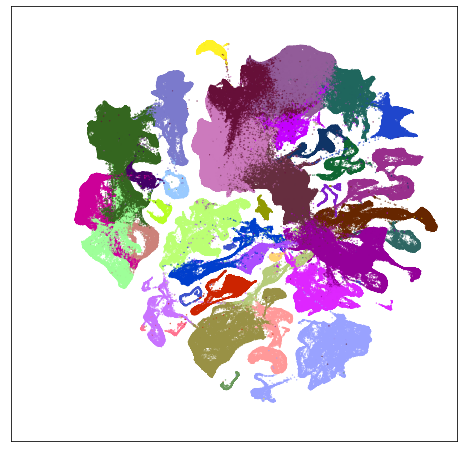

In [9]:
group = 'Pallium-Glut'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

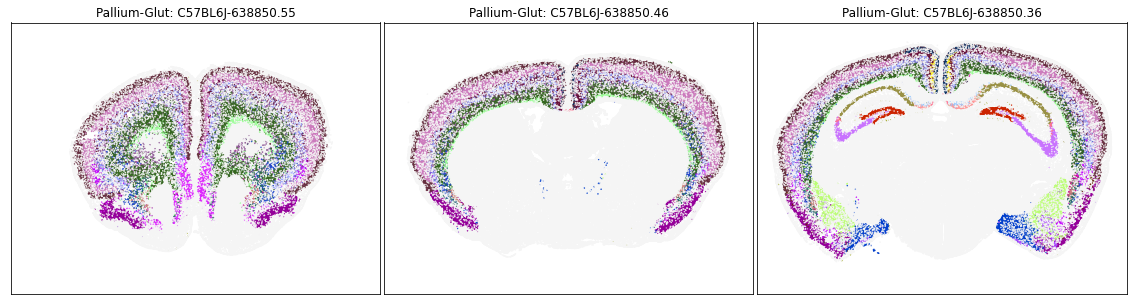

In [10]:
blist = ['C57BL6J-638850.55','C57BL6J-638850.46','C57BL6J-638850.36']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

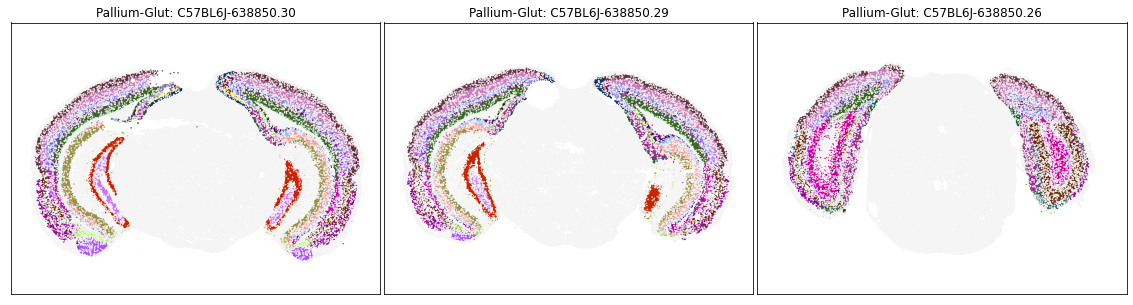

In [11]:
blist = ['C57BL6J-638850.30','C57BL6J-638850.29','C57BL6J-638850.26']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: Subpallium-GABA

Figure 2 (b) and (g)

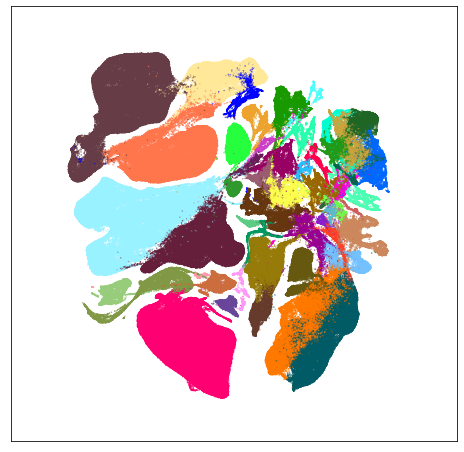

In [12]:
group = 'Subpallium-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

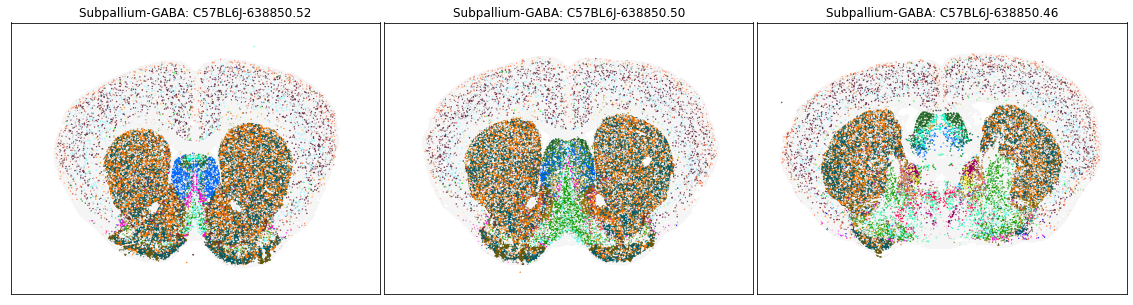

In [13]:
blist = ['C57BL6J-638850.52','C57BL6J-638850.50','C57BL6J-638850.46']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

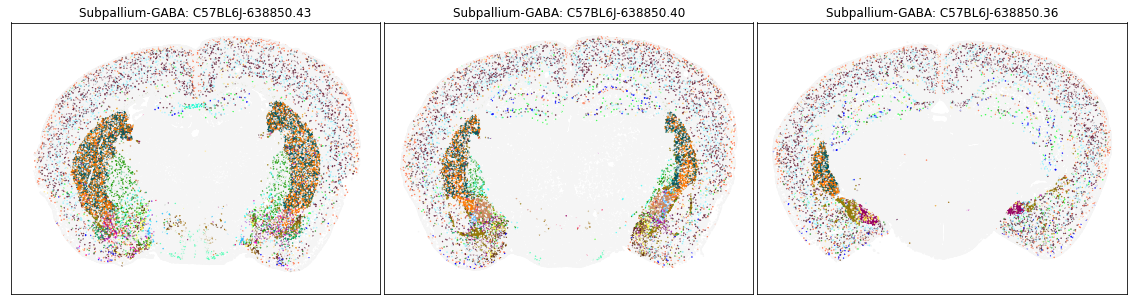

In [14]:
blist = ['C57BL6J-638850.43','C57BL6J-638850.40','C57BL6J-638850.36']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: HY-EA-Glut-GABA

Similar to Figure (c) and (f)

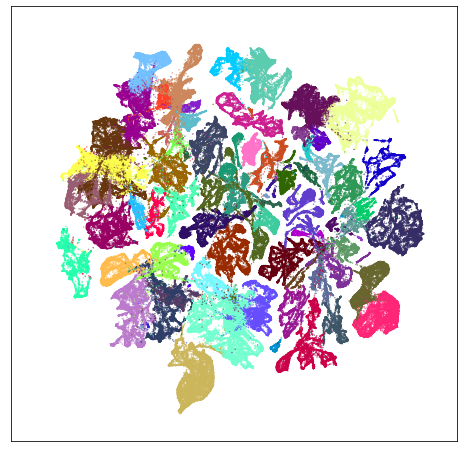

In [15]:
group = 'HY-EA-Glut-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

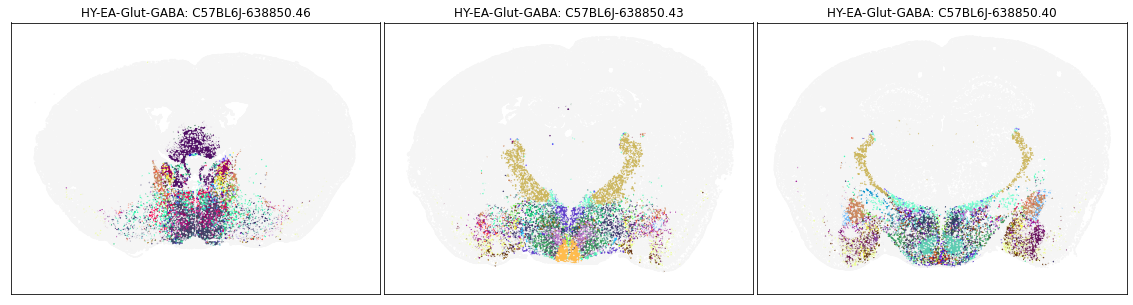

In [16]:
blist = ['C57BL6J-638850.46','C57BL6J-638850.43','C57BL6J-638850.40']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

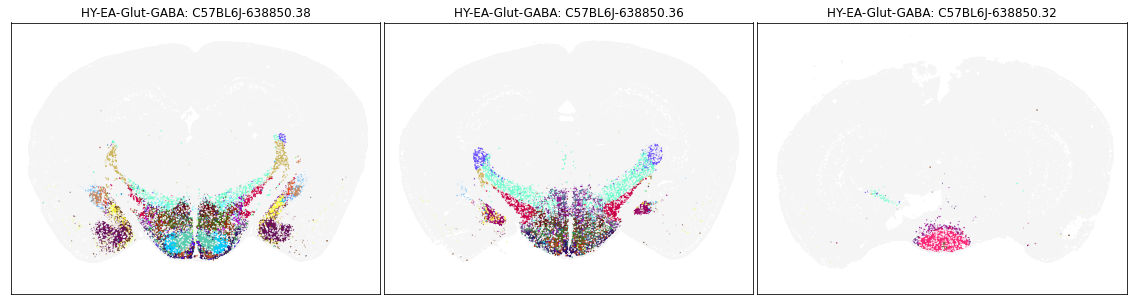

In [17]:
blist = ['C57BL6J-638850.38','C57BL6J-638850.36','C57BL6J-638850.32']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: TH-EPI-Glut

Figure 2 (d) and (i)

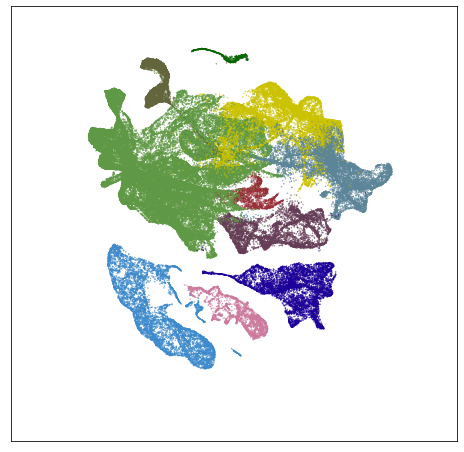

In [18]:
group = 'TH-EPI-Glut'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

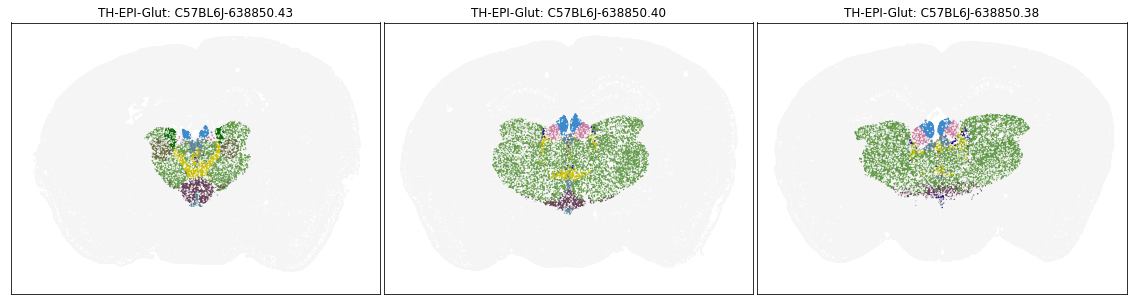

In [19]:
blist = ['C57BL6J-638850.43','C57BL6J-638850.40','C57BL6J-638850.38']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

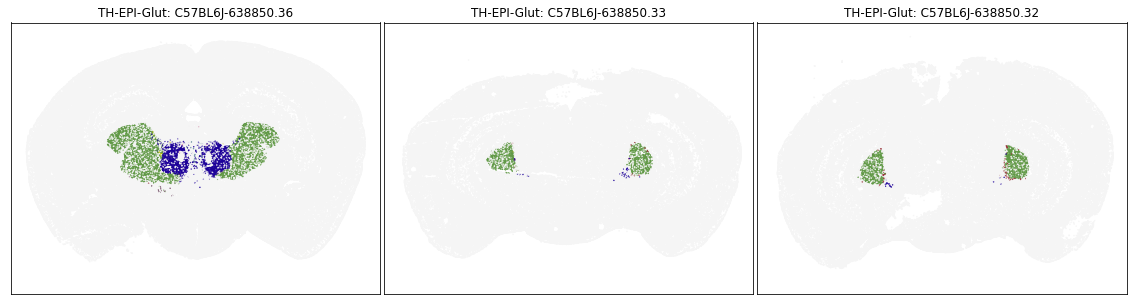

In [20]:
blist = ['C57BL6J-638850.36','C57BL6J-638850.33','C57BL6J-638850.32']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: MB-HB-CB-GABA	

Figure 2 (e) and (j)

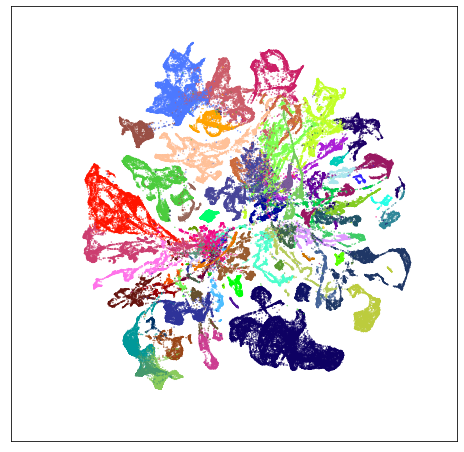

In [21]:
group = 'MB-HB-CB-GABA'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

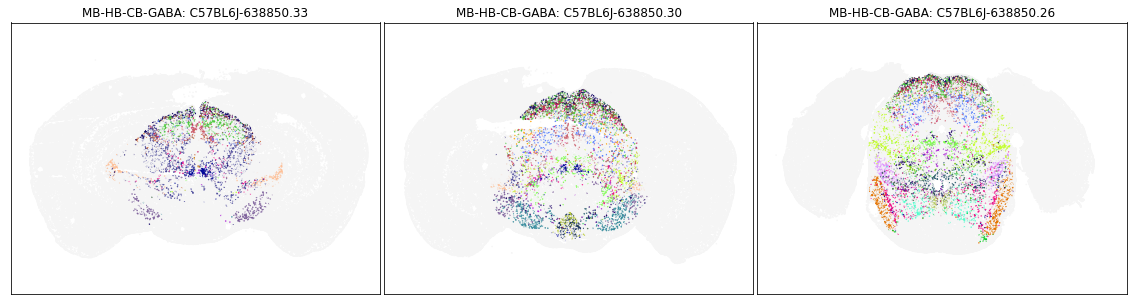

In [22]:
blist = ['C57BL6J-638850.33','C57BL6J-638850.30','C57BL6J-638850.26']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

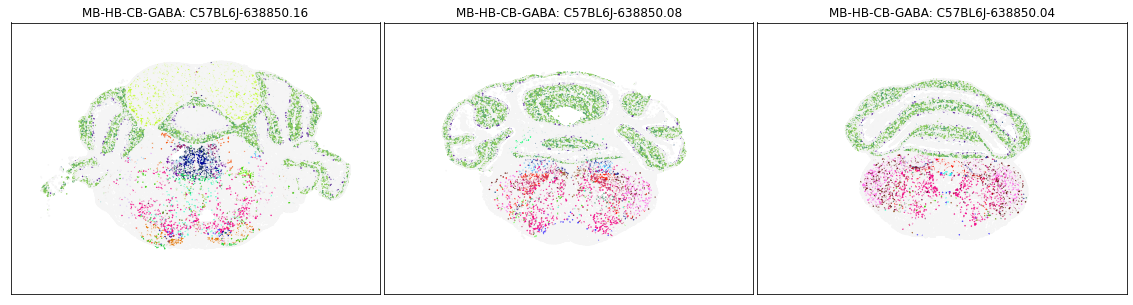

In [23]:
blist = ['C57BL6J-638850.16','C57BL6J-638850.08','C57BL6J-638850.04']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: MB-HB-Glut-Sero-Dopa

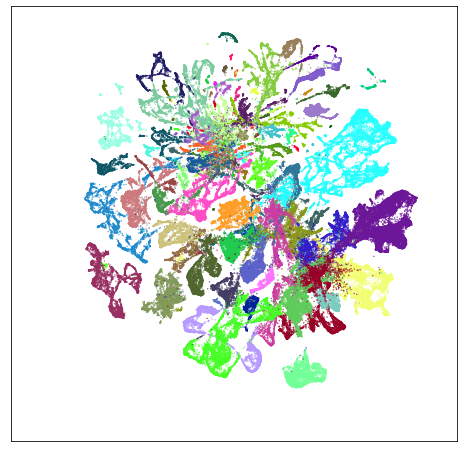

In [24]:
group = 'MB-HB-Glut-Sero-Dopa'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

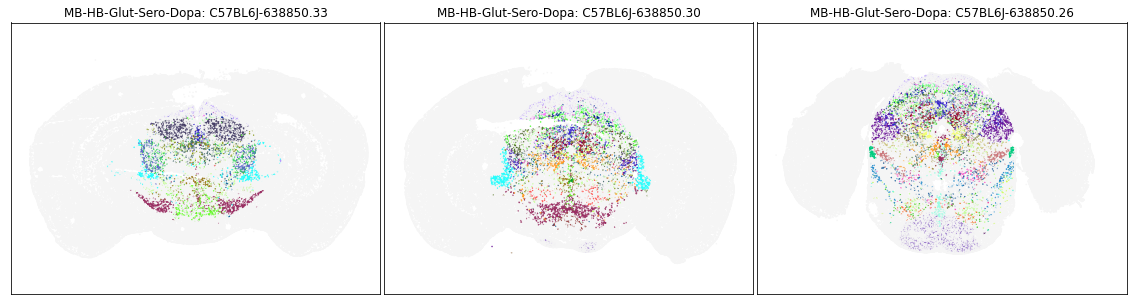

In [25]:
blist = ['C57BL6J-638850.33','C57BL6J-638850.30','C57BL6J-638850.26']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

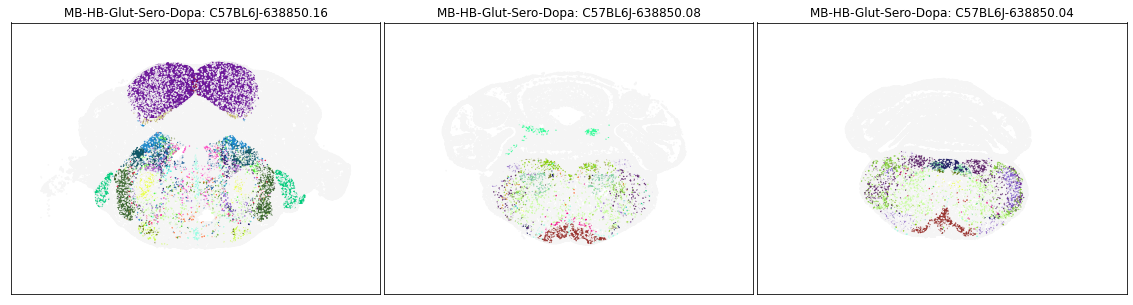

In [26]:
blist = ['C57BL6J-638850.16','C57BL6J-638850.08','C57BL6J-638850.04']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

### Neighborhood: NN-IMN-GC

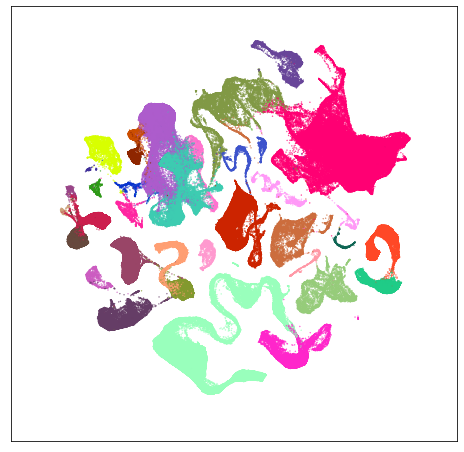

In [27]:
group = 'NN-IMN-GC'
coord = fetch_coord(group)
fig, ax = plot_umap( coord['x'], coord['y'], cc=cell_10x.loc[coord.index,'subclass_color'])

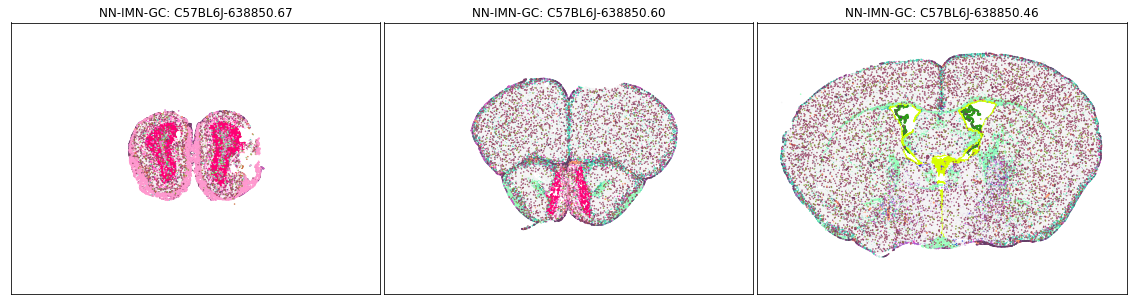

In [28]:
blist = ['C57BL6J-638850.67','C57BL6J-638850.60','C57BL6J-638850.46']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )

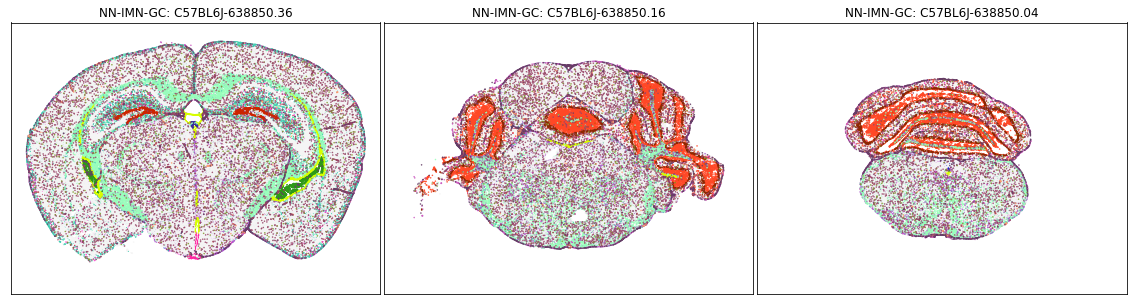

In [29]:
blist = ['C57BL6J-638850.36','C57BL6J-638850.16','C57BL6J-638850.04']
fig, ax = plot_sections( cell_merfish, group, 'subclass_color', blist )